In [1]:
import numpy as np
import torch
import os
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

In [16]:
# Load the data from the specified directory
X_train = np.load('ProcessedInputData/X_train.npy')
Y_train = np.load('ProcessedInputData/y_train.npy')
X_val = np.load('ProcessedInputData/X_val.npy')
Y_val = np.load('ProcessedInputData/y_val.npy')


# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.long)

# Create a DataLoader for batching
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) # don't shuffle for LTSM?
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [3]:
# Print the first few elements of the tensors
print("First few elements of Y_train_tensor:")
print(Y_train_tensor.size())
print(Y_train_tensor[:10])  # Print first 10 elements

print("First few elements of X_train_tensor:")
print(X_train_tensor.size())
# print(X_train_tensor[:3])  # Print first 3 elements

# each input is 5x90x1 matrix
# 5 bc there are 5 eeg channels recordings per sample,
# 90 bc i did fourier transform and binned it into 90 different bins from 0.5 to 40 Hz (relevant frequencies for EEG)
# the 1 was added just to be the dimension of picture style for CNN so its like black and white

print("Val tensors:")
print(Y_val_tensor.size())
print(X_val_tensor.size())

First few elements of Y_train_tensor:
torch.Size([3153])
tensor([1, 1, 1, 1, 0, 0, 0, 1, 0, 0])
First few elements of X_train_tensor:
torch.Size([3153, 5, 90, 1])
Val tensors:
torch.Size([394])
torch.Size([394, 5, 90, 1])


In [4]:
sanity_dataset = TensorDataset(X_train_tensor[:20], Y_train_tensor[:20]) # take just a few elements
sanity_loader = DataLoader(sanity_dataset, batch_size=5, shuffle=True)

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)  # Xavier initialization
        if m.bias is not None:
            nn.init.zeros_(m.bias)  # Initialize biases to zero

In [14]:
import torch
import torch.nn as nn

class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()

        # CNN Layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)  
        self.relu = nn.ReLU()

        # Compute CNN output size dynamically
        self._to_linear = None
        self._compute_linear_input_size()

        # LSTM Layer (input_size = CNN feature size per timestep)
        self.lstm = nn.LSTM(input_size=self._to_linear, hidden_size=64, num_layers=1, batch_first=True)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64, 1)  

    def _compute_linear_input_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, 5, 90)  # Dummy input
            x = self.pool(self.relu(self.conv1(x)))  
            x = self.pool(self.relu(self.conv2(x)))  
            x = x.permute(0, 2, 1, 3).contiguous()  # Change to (batch, time_steps, channels, features)
            x = x.view(x.size(0), x.size(1), -1)  # Flatten last two dimensions
            self._to_linear = x.shape[2]  # Extract feature size per timestep

    def forward(self, x):
        x = x.view(-1, 1, 5, 90)  # Ensure correct shape
        x = self.pool(self.relu(self.conv1(x)))  
        x = self.pool(self.relu(self.conv2(x)))  

        # Reshape for LSTM (batch, time_steps, features)
        x = x.permute(0, 2, 1, 3).contiguous()  # (batch, time_steps, channels, features)
        x = x.view(x.size(0), x.size(1), -1)  # Flatten (batch, time_steps, features)

        # Pass through LSTM
        x, _ = self.lstm(x)  # LSTM output shape: (batch, time_steps, hidden_size)
        x = x[:, -1, :]  # Take last time step's output

        # Fully Connected Output Layer
        x = self.fc1(x)  # Shape: (batch, 1)
        return x  # No sigmoid (for regression tasks)


# Training Function
def train_model(model, train_loader, epochs=10):
    torch.manual_seed(1000)
    model.train()
    criterion = nn.BCEWithLogitsLoss()  
    optimizer = optim.SGD(model.parameters(), lr=0.001)  # Use Adam

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.view(-1, 1).float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Convert logits to probabilities and round
            predicted = torch.round(torch.sigmoid(outputs))  
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Initialize Model
cnn_model = CNN()
cnn_model.apply(init_weights)  # Apply Xavier Initialization

# Train Model
train_model(model=cnn_model, train_loader=sanity_loader, epochs=50)

Epoch [1/50], Loss: 594.0648, Accuracy: 65.00%
Epoch [2/50], Loss: 71.9276, Accuracy: 50.00%
Epoch [3/50], Loss: 273.7378, Accuracy: 55.00%
Epoch [4/50], Loss: 18.5318, Accuracy: 45.00%
Epoch [5/50], Loss: 9.5721, Accuracy: 65.00%
Epoch [6/50], Loss: 0.5833, Accuracy: 60.00%
Epoch [7/50], Loss: 0.4788, Accuracy: 70.00%
Epoch [8/50], Loss: 0.4629, Accuracy: 70.00%
Epoch [9/50], Loss: 1.0579, Accuracy: 55.00%
Epoch [10/50], Loss: 0.8516, Accuracy: 60.00%
Epoch [11/50], Loss: 0.6613, Accuracy: 55.00%
Epoch [12/50], Loss: 0.8585, Accuracy: 45.00%
Epoch [13/50], Loss: 0.6588, Accuracy: 45.00%
Epoch [14/50], Loss: 0.6575, Accuracy: 45.00%
Epoch [15/50], Loss: 0.6475, Accuracy: 50.00%
Epoch [16/50], Loss: 0.6451, Accuracy: 50.00%
Epoch [17/50], Loss: 0.6367, Accuracy: 50.00%
Epoch [18/50], Loss: 0.6343, Accuracy: 50.00%
Epoch [19/50], Loss: 0.6269, Accuracy: 50.00%
Epoch [20/50], Loss: 0.6251, Accuracy: 50.00%
Epoch [21/50], Loss: 0.6198, Accuracy: 55.00%
Epoch [22/50], Loss: 0.6209, Accuracy

Epoch [1/100]
Train Loss: 23.4041 | Train Accuracy: 50.81%
Val Loss: 33.8099 | Val Accuracy: 48.98%

Epoch [2/100]
Train Loss: 53.0714 | Train Accuracy: 52.27%
Val Loss: 20.3284 | Val Accuracy: 50.76%

Epoch [3/100]
Train Loss: 31.4770 | Train Accuracy: 50.97%
Val Loss: 5.0346 | Val Accuracy: 51.78%

Epoch [4/100]
Train Loss: 6.3865 | Train Accuracy: 54.23%
Val Loss: 13.6998 | Val Accuracy: 51.02%

Epoch [5/100]
Train Loss: 22.0370 | Train Accuracy: 51.16%
Val Loss: 3.8397 | Val Accuracy: 51.78%

Epoch [6/100]
Train Loss: 4.2809 | Train Accuracy: 54.04%
Val Loss: 3.4449 | Val Accuracy: 53.81%

Epoch [7/100]
Train Loss: 6.8155 | Train Accuracy: 53.54%
Val Loss: 10.9767 | Val Accuracy: 50.25%

Epoch [8/100]
Train Loss: 25.1731 | Train Accuracy: 51.67%
Val Loss: 4.4195 | Val Accuracy: 51.52%

Epoch [9/100]
Train Loss: 5.6088 | Train Accuracy: 53.57%
Val Loss: 2.6767 | Val Accuracy: 50.00%

Epoch [10/100]
Train Loss: 7.7753 | Train Accuracy: 53.19%
Val Loss: 1.9215 | Val Accuracy: 52.28%



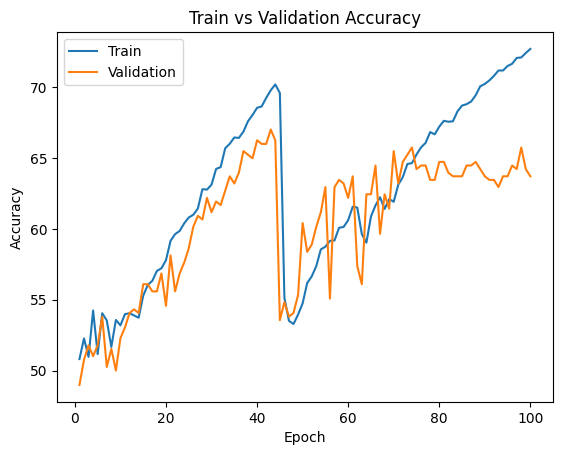

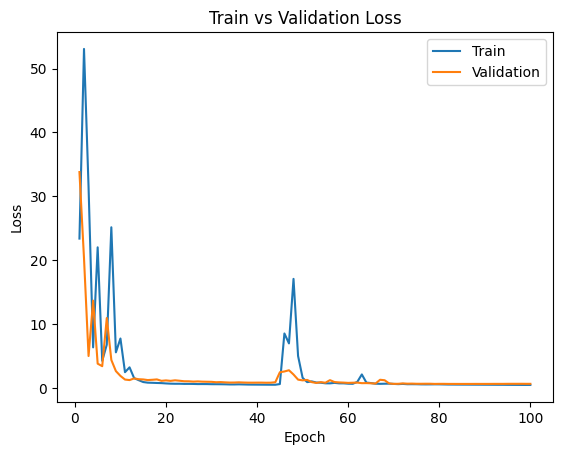

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=704, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [17]:
def train_and_validate(model, train_loader, val_loader, epochs=100, patience=20):
    torch.manual_seed(1000)
    model.train()
    criterion = nn.BCEWithLogitsLoss()  
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float("inf")  # Initialize best validation loss
    patience_counter = 0  # Counts epochs without improvement
    best_model_state = None  # Store best model weights

    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.view(-1, 1).float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = torch.round(torch.sigmoid(outputs))  
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation loop (no gradient updates)
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                labels = labels.view(-1, 1).float()
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = torch.round(torch.sigmoid(outputs))
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        # Print results
        print(f"Epoch [{epoch+1}/{epochs}]")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%\n")

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # Early Stopping Logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss  # Update best loss
            patience_counter = 0  # Reset counter
            best_model_state = model.state_dict()  # Save best model
        else:
            patience_counter += 1  # Increment counter

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break  # Stop training

    # Load best model before exiting
    if best_model_state:
        model.load_state_dict(best_model_state)
        print("Loaded best model with lowest validation loss.")

    # Plot the curves
    import matplotlib.pyplot as plt
    plt.title("Train vs Validation Accuracy")
    n = len(train_accuracies) # number of epochs
    plt.plot(range(1,n+1), train_accuracies, label="Train")
    plt.plot(range(1,n+1), val_accuracies, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_losses, label="Train")
    plt.plot(range(1,n+1), val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    return model  # Return best model

# Instantiate and train the CNN
cnn_model = CNN()
cnn_model.apply(init_weights)  # Initialize weights
train_and_validate(cnn_model, train_loader, val_loader, epochs=100)

In [9]:
# Load test data
X_test = np.load("ProcessedInputData/X_test.npy")
y_test = np.load("ProcessedInputData/y_test.npy")

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create a DataLoader for batching
batch_size = 64
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    criterion = nn.BCEWithLogitsLoss()  # Same loss function as training

    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():  # No gradients needed for evaluation
        for inputs, labels in test_loader:
            outputs = model(inputs)  # Get raw logits
            labels = labels.view(-1, 1).float()

            # Compute loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Convert logits to probabilities
            probs = torch.sigmoid(outputs)  # Convert logits to probabilities
            predicted = torch.round(probs)  # Round to 0 or 1

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Store labels and predictions for confusion matrix & ROC curve
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Compute final loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Generate and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Generate and plot ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

ModuleNotFoundError: No module named 'sklearn'

Test Loss: 0.6701, Test Accuracy: 61.01%


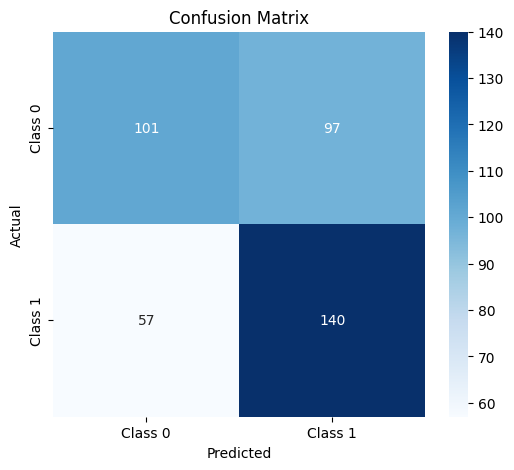

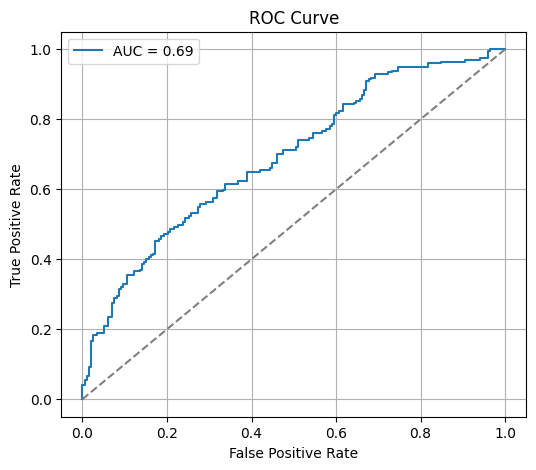

In [38]:
evaluate_model(cnn_model, test_loader)